<h1> Welcome to my Titanic Kernel! </h1>

Here you find basic Data Exploration and Visualization, data handling with some features, and modelling.

**This Kernel Focus on the effects of some features in the performance of the learning algorithms** 


I used most the common supervise learning classification algorithms. 
I compared them in a train/test set and I chose some for submiting the answers

 Table of Contents:
 
 **1. [Introduction & Imports](#Introduction)** <br>
 **2. [Exploratory Data Analysis](#EDA)** <br>
 **3. [Feature Engineering](#Feature)** <br>
 **4. [Preparing the Test dataframe](#test)** <br>
 **5. [Testing several Supervise learning models](#ML)** <br>
 **6. [Trainning all data on some Classifiers](#train)** <br>
 **7. [Results](#results)** <br>


<a id="Introduction"></a> <br> 
 **1. Introduction & Imports** 


Import some libraries for data exploration

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import os
#print(os.listdir("../input"))

**Import Data & Exploratory Data Analysis**

In [2]:
train = pd.read_csv('TrainTitanic.csv', delimiter=',')
#drop cabin, Name and Ticket data that are not neccesary to train the model
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id="EDA"></a> <br> 
 **2. Exploratory Data Analysis**

The first step is the detect in which columns there are non valid values

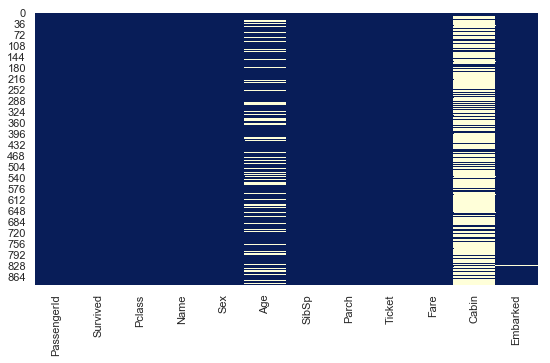

In [3]:
#Check for the missing values in the columns 
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

Supposing that the categorical values such as the Name, the Cabin, the Ticket code and the ID doesnt have any relationship to the fact that the passanger died or survived:

In [4]:
#I drop those columns
train = train.drop(columns = ['Cabin','Name','Ticket','PassengerId'])

In [5]:
#filling Non valid values with mean for age, 
train['Age'].fillna((train['Age'].mean()), inplace=True)

**Survival as function of Pclass and Sex**


To start the exploration, it is possible to group passanger by Sex and Class, these groups could give insights if higher class have better chance of survive, or woman have better chance than men for example.

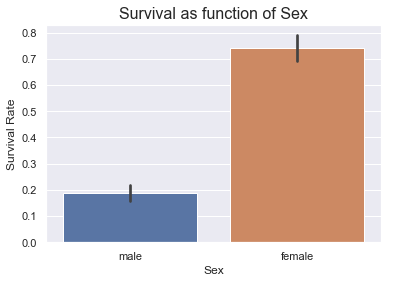

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [6]:
sns.barplot(x='Sex', y='Survived', data=train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Sex", fontsize=16)

plt.show()
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

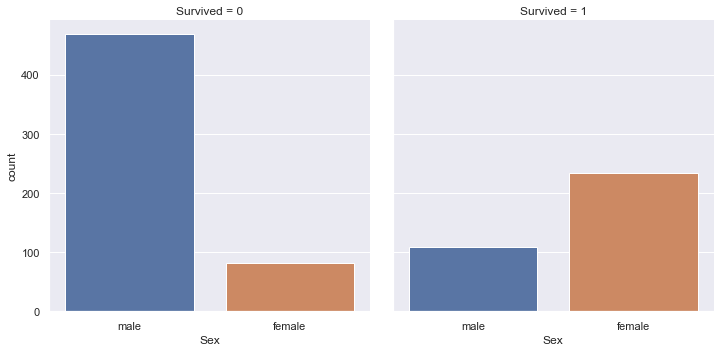

In [7]:
#This information can be displayed in the next plot too:
sns.catplot(x='Sex', col='Survived', kind='count', data=train);

It is clear that women have better chance than men. 
If you create a model saying that only woman survive it would have a score of **0.76555**, so the mission is to create a model at least better

Next, I explore the change of survive regardign the passanger Class:

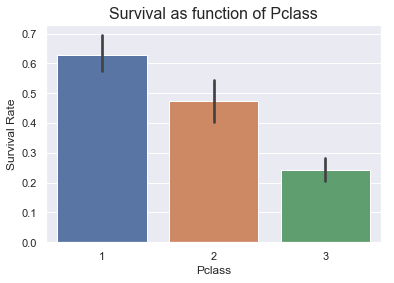

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [8]:
sns.barplot(x='Pclass', y='Survived', data=train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Pclass", fontsize=16)

plt.show()
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

 I explore both PClass and Sex in the same plot:

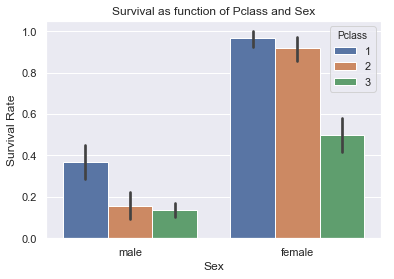

In [9]:
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Pclass and Sex")
plt.show()

Next, Explore the Parch and SibSp column:

In [10]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [11]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


To get a better insight of the relationship of these features and the survival rate, a general pairplot will give some clues:

d:\Profiles\fesanchez\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
d:\Profiles\fesanchez\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


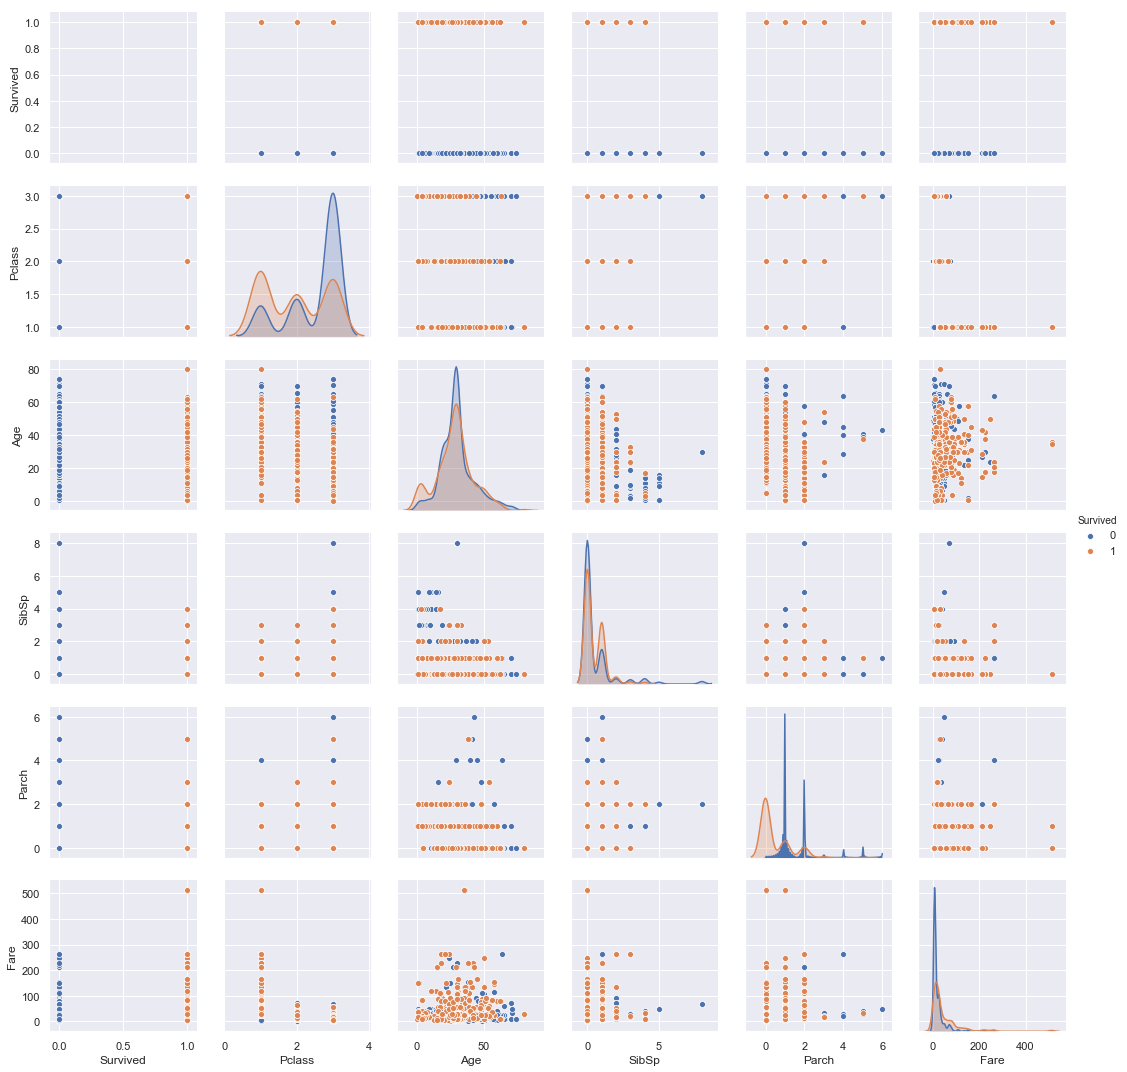

In [12]:
sns.pairplot(data=train, hue="Survived")

<a id="Feature"></a> <br> 
 **3. Feature Engineering**

The features can be built to:
- reduce the number of states of the SibSp and Parch column
- Create smaller classes for continues columns, such as Age and Fare
- Create new columns that could improve prediction: such as if the passanger is alone or not
- Drop columns that doesn't improve predictions

The first features to work on are SibSp and Parch

d:\Profiles\fesanchez\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


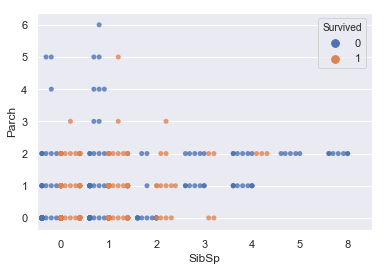

In [13]:
# I Create a swarmplot to detect patterns, where is the highest survival rate? 
sns.swarmplot(x = 'SibSp', y = 'Parch', hue = 'Survived', data = train, split = True, alpha=0.8)
plt.show()

To explore better the relationship between these variables before featuring, I create a first model:

In [14]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

yf = train.Survived
base_features = ['Parch',
                 'SibSp','Age', 'Fare','Pclass']

Xf = train[base_features]

train_X, val_X, train_y, val_y = train_test_split(Xf, yf, random_state=1)
first_model = RandomForestRegressor(n_estimators=21, random_state=1).fit(train_X, train_y)

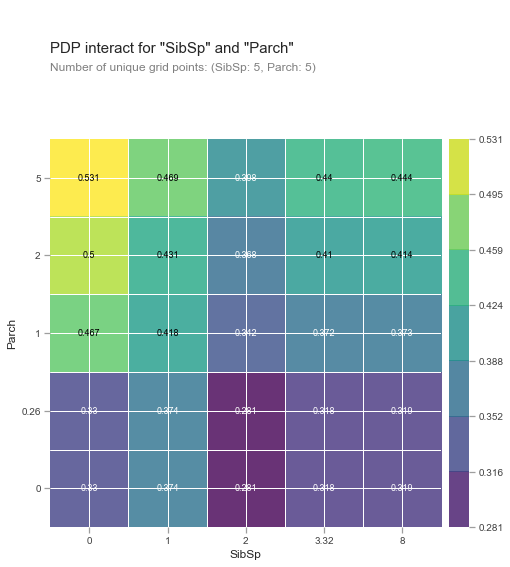

In [15]:
#Explore the relationship between SipSp and Parch in the predictions for a RF Model
inter  =  pdp.pdp_interact(model=first_model, dataset=val_X, model_features=base_features, features=['SibSp', 'Parch'],num_grid_points=[20, 20])
pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=['SibSp', 'Parch'], plot_type='grid')
plt.show()

Then, introducing new features as Family size (to join these Parch and SibSp)

In [16]:
train['FamilySize'] = train['SibSp'] + train['Parch'] 
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).agg('mean')

,FamilySize,Survived
0,0,0.303538
1,1,0.552795
2,2,0.578431
3,3,0.724138
4,4,0.200000
5,5,0.136364
6,6,0.333333
7,7,0.000000
8,10,0.000000


The next option is to cerate IsAlone feature to check wheter a person traveling alolne is more likely to survived or died

In [17]:
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 0, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


To sum up the work, the next set of graphics shows the relationships with and without the new features

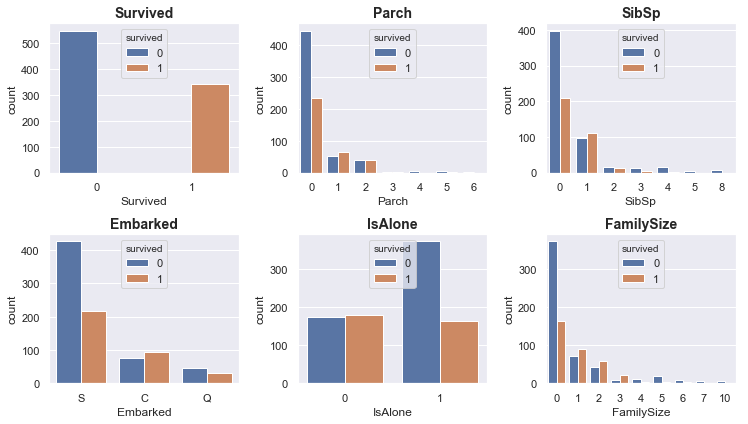

In [18]:
cols = ['Survived', 'Parch', 'SibSp', 'Embarked','IsAlone', 'FamilySize']

nr_rows = 2
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.countplot(train[cols[i]], hue=train["Survived"], ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        ax.legend(title="survived", loc='upper center') 
        
plt.tight_layout()

**The Fare Column**

This continus feature could be converted in a continues feature in order to increase prediction of the model

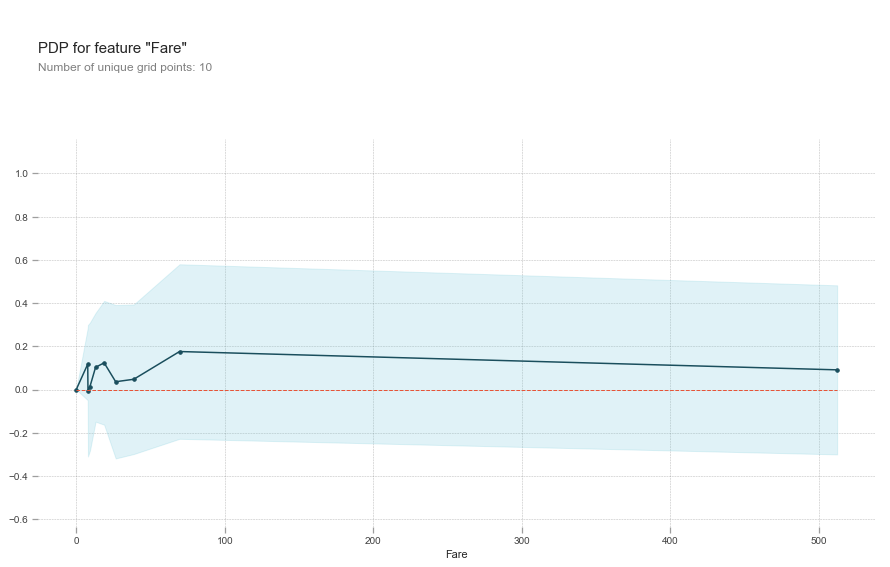

In [19]:
feat_name = 'Fare'
pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

The fare is distributed in several continues values, and it is not clear how can we discretize these values to improve model's performance.

To solve this problem, first, it would be likely to think that the chance of survival could depend on the Fare

In [20]:
train[["Fare", "Survived"]].groupby(['Survived'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Survived,Fare
1,1,48.395408
0,0,22.117887


Highest fare mean improve the chance of survival
We know that female have better chance than male, so we group the data in these values:

In [21]:
train.groupby(['Sex','Survived'])[['Fare']].agg(['min','mean','max'])

Fare                     
                   min       mean       max
Sex    Survived                            
female 0         6.750  23.024385  151.5500
       1         7.225  51.938573  512.3292
male   0         0.000  21.960993  263.0000
       1         0.000  40.821484  512.3292

Based on the exploration of the data, I propose to discretize the Fare in four states:

In [22]:
train.loc[ train['Fare'] <= 7.22, 'Fare'] = 0
train.loc[(train['Fare'] > 7.22) & (train['Fare'] <= 21.96), 'Fare'] = 1
train.loc[(train['Fare'] > 21.96) & (train['Fare'] <= 40.82), 'Fare'] = 2
train.loc[ train['Fare'] > 40.82, 'Fare'] = 3
train['Fare'] = train['Fare'].astype(int)

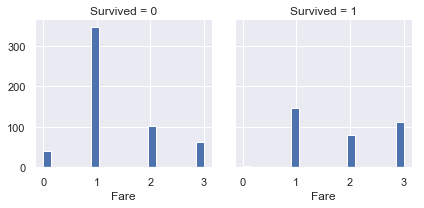

In [23]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Fare', bins=20)
plt.show()

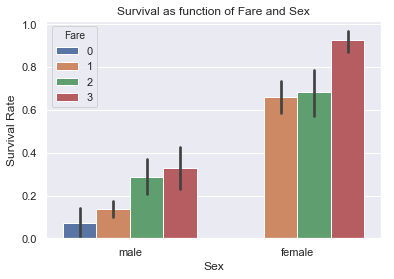

In [24]:
sns.barplot(x='Sex', y='Survived', hue='Fare', data=train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Fare and Sex")
plt.show()

This plot show us how the new fare states are relatid to Sex and rate of survival. Higher fare have better chance of survive than lower fare, and female more than male in general.

**Now the relationship between age and survived**

Age has continue values too:

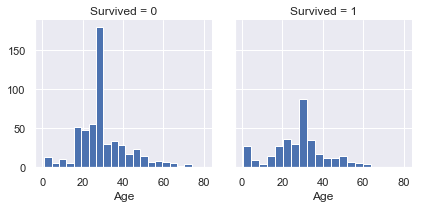

In [25]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

I check in a first model how can age correlate with the chance of survive, also related to the passanger Class:

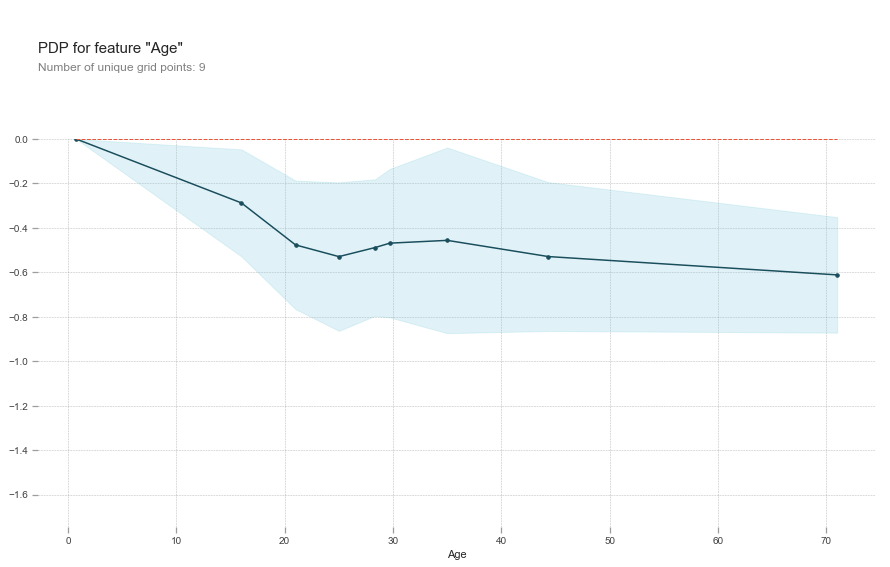

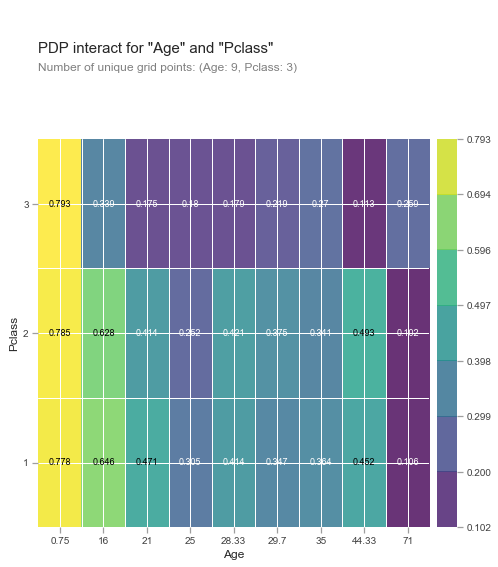

In [27]:
feat_name = 'Age'
pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
#Exploring the relationship between Age and Pclass for a given model preductions
inter  =  pdp.pdp_interact(model=first_model, dataset=val_X, model_features=base_features, features=['Age', 'Pclass'])

pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=['Age', 'Pclass'], plot_type='grid')
plt.show()

It seems like less age and higher class is a better combination to survive. 

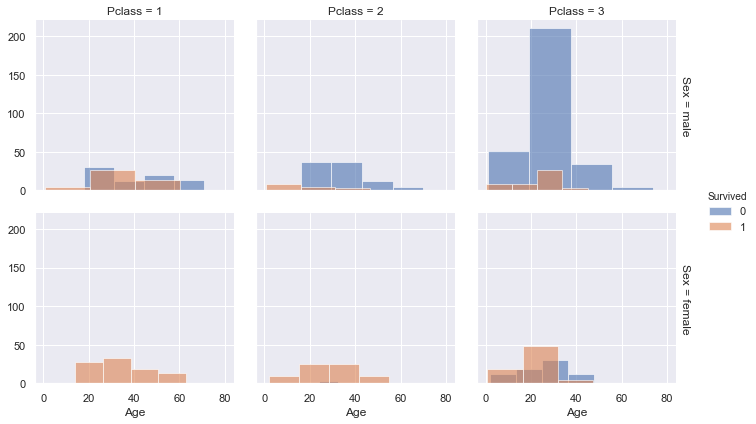

In [28]:
#bins=np.arange(0, 80, 10)
g = sns.FacetGrid(train, row='Sex', col='Pclass', hue='Survived', margin_titles=True, size=3, aspect=1.1)
g.map(sns.distplot, 'Age', kde=False, bins=4, hist_kws=dict(alpha=0.6))
g.add_legend()  
plt.show()

Following the graphics below, The age can be groupped into less classes:

In [29]:
train.loc[ train['Age'] <= 16, 'Age'] = 1
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), 'Age'] = 2
train.loc[(train['Age'] > 32) & (train['Age'] <= 64), 'Age'] = 3
train.loc[ train['Age'] > 64, 'Age'] = 4
train['Age'] = train['Age'].astype(int)

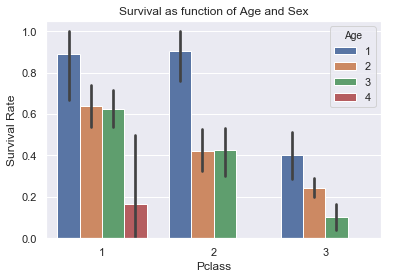

In [30]:
sns.barplot(x='Pclass', y='Survived', hue='Age', data=train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Age and Sex")
plt.show()

This plot show us how higher class and lower age have better chance of survive, while lower class (3) and older (age >2) have lower chance of survive.
This seems logic, the reduction of classes can improve the learning of the model based on the (relative small) data we have  

finally I explore new features, for example, a measure of 'Age x Class' would give better insight of the survival rate? 

In [31]:
train['Age*Class'] = train.Age * train.Pclass

In [32]:
train[["Age*Class", "Survived"]].groupby(['Age*Class'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Age*Class,Survived
0,1,0.888889
1,2,0.690909
2,3,0.538462
3,4,0.405941
4,6,0.274074
6,9,0.101266
5,8,0.000000
7,12,0.000000


Less values give a clue of more survival mean, however a crosstab maybe would give more clear information:

In [33]:
pd.crosstab([train.Survived], [train.Sex,train['Age*Class']], margins=True).style.background_gradient(cmap='autumn_r')

the new featre show how female in AgexClass between 2 to 6 have better chance of survive, and male from 4 to 6 AgexClass have lower chance of survive 

The same analysis for the IsAlone feature:

In [34]:
pd.crosstab([train.Survived], [train.Sex,train['IsAlone']], margins=True).style.background_gradient(cmap='autumn_r')

men who were alone have lower chance of survive

In [35]:
pd.crosstab([train.Survived], [train.Fare], margins=True).style.background_gradient(cmap='autumn_r')

Fare,0,1,2,3,All
Survived,,,,,
0,40,346,101,62,549
1,3,146,80,113,342
All,43,492,181,175,891


This last crosstab show how the people having Fare group 1 (Fare > 7.22 & Fare <= 21.96) have the lower chance of survive, 

The presented groupes show the tendency of the data. However is hard to know wheter these groups really optimize the larning. This work only can be done by trial and error

**Estimation of the Survival rate using the new features defined **

this is how the new train dataframe looks like:

In [36]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Age*Class
0,0,3,male,2,1,0,1,S,1,0,6
1,1,1,female,3,1,0,3,C,1,0,3
2,1,3,female,2,0,0,1,S,0,1,6
3,1,1,female,3,1,0,3,S,1,0,3
4,0,3,male,3,0,0,1,S,0,1,9


Now, I would simulate the training using the new features 

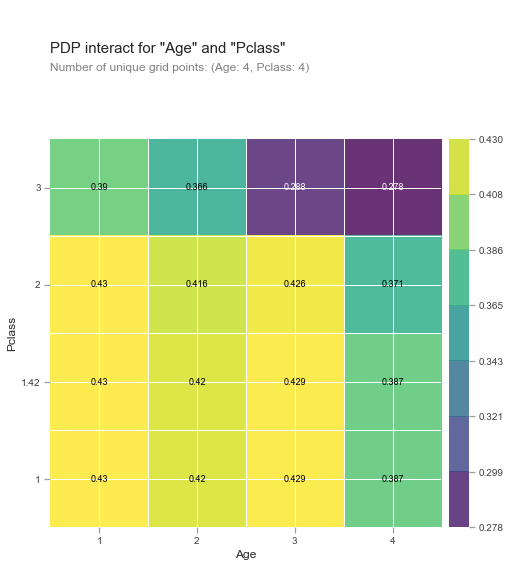

In [37]:
y2 = train.Survived

base_features2 = ['Parch','SibSp','Age', 'Fare','Pclass','Age*Class','FamilySize','IsAlone']

X2 = train[base_features2]
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, random_state=1)
second_model = RandomForestRegressor(n_estimators=21, random_state=1).fit(train_X2, train_y2)

inter2  =  pdp.pdp_interact(model=second_model, dataset=val_X2, model_features=base_features2, features=['Age', 'Pclass'],num_grid_points=[20, 20])
pdp.pdp_interact_plot(pdp_interact_out=inter2, feature_names=['Age', 'Pclass'], plot_type='grid')
plt.show()

These new features provide a more clear distribution that the dataframe without features:

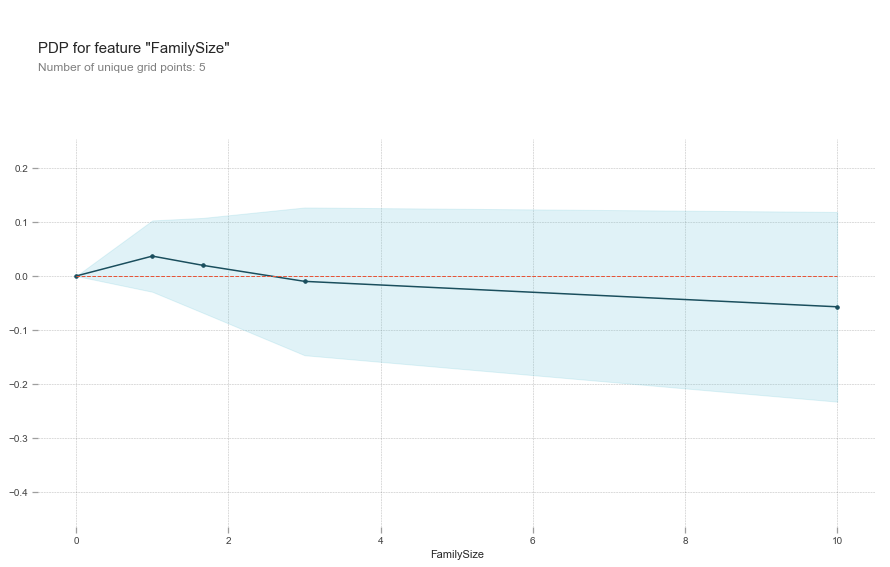

In [38]:
feat_name = 'FamilySize'
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=val_X2, model_features=base_features2, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

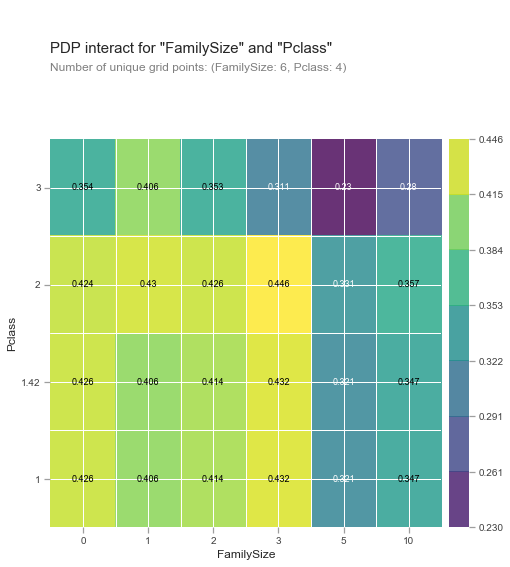

In [39]:
inter2  =  pdp.pdp_interact(model=second_model, dataset=val_X2, model_features=base_features2, features=['FamilySize', 'Pclass'],num_grid_points=[20, 20])
pdp.pdp_interact_plot(pdp_interact_out=inter2, feature_names=['FamilySize', 'Pclass'], plot_type='grid',x_quantile=True
                                  )
plt.show()

Also for the Passanger Class and its family size. After defining the new groups, it's more clear for the algorithm that lower class and lower family size increase the chance of survive 

Now I explore the effects of the other featuers independently

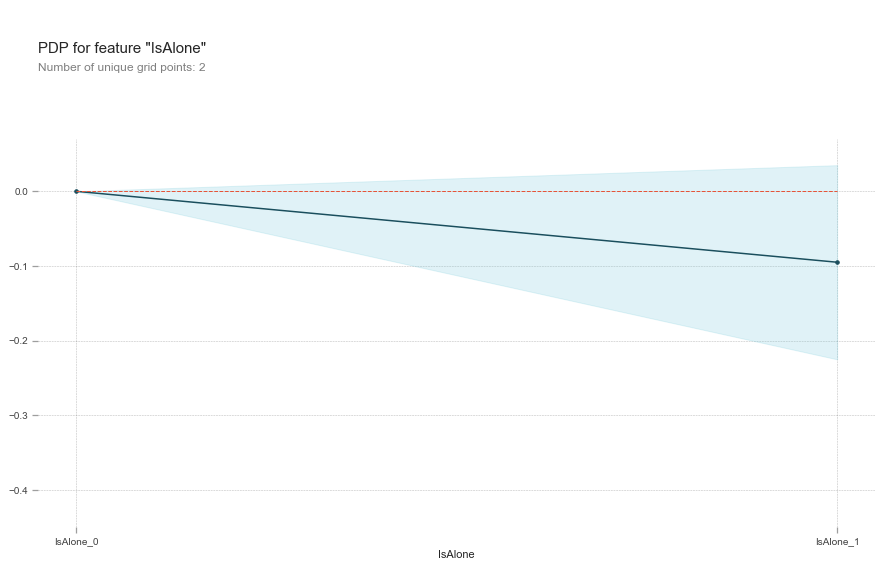

In [40]:
feat_name = 'IsAlone'
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=val_X2, model_features=base_features2, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

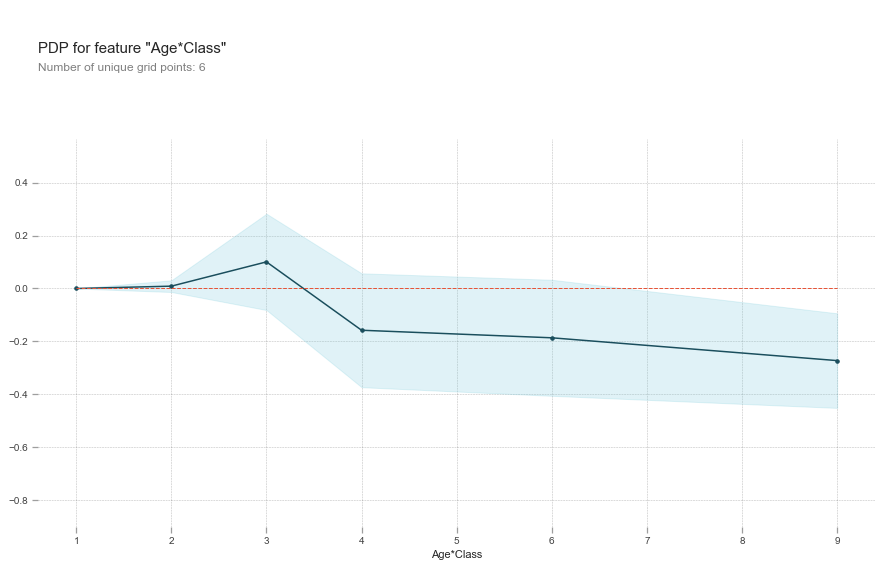

In [41]:
feat_name = 'Age*Class'
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=val_X2, model_features=base_features2, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

For Is alone and AgexClass, the effect in the survival rate is not that clear

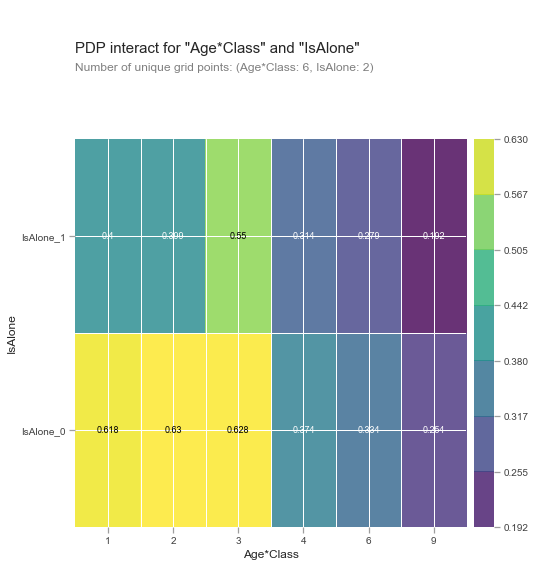

In [42]:
inter2  =  pdp.pdp_interact(model=second_model, dataset=val_X2, model_features=base_features2, features=['Age*Class', 'IsAlone'],num_grid_points=[20, 20])
pdp.pdp_interact_plot(pdp_interact_out=inter2, feature_names=['Age*Class', 'IsAlone'], plot_type='grid')
plt.show()

As Sex and Embarked are not numerical I do the pandas OneHotEncoder:

In [43]:
# convert Sex values and Embearked values into dummis to use a numerical classifier 
dummies_Sex = pd.get_dummies(train.Sex)
dummies_Embarked = pd.get_dummies(train.Embarked)
#join the dummies to the final dataframe
train_ready = pd.concat([train, dummies_Sex,dummies_Embarked], axis=1)
train_ready.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Age*Class,female,male,C,Q,S
0,0,3,male,2,1,0,1,S,1,0,6,0,1,0,0,1
1,1,1,female,3,1,0,3,C,1,0,3,1,0,1,0,0
2,1,3,female,2,0,0,1,S,0,1,6,1,0,0,0,1
3,1,1,female,3,1,0,3,S,1,0,3,1,0,0,0,1
4,0,3,male,3,0,0,1,S,0,1,9,0,1,0,0,1


and drop the respective columns:

In [44]:
#Drop the columns that are not usefull now
#train_ready = train_ready.drop(columns = ['Sex','Embarked','male','SibSp','Parch','Q'])

train_ready = train_ready.drop(columns = ['Sex','Embarked'])

the AgexClass can be dropped or not as I experiment to increase the general performance of the model in the next steps:

In [45]:
#train_ready = train_ready.drop(columns = ['Age*Class'])

same for the FamiliSize columns

In [46]:
#train_ready = train_ready.drop(columns = ['FamilySize'])

In [47]:
#alst check before trainning
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Age           891 non-null int32
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null int32
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Age*Class     891 non-null int64
female        891 non-null uint8
male          891 non-null uint8
C             891 non-null uint8
Q             891 non-null uint8
S             891 non-null uint8
dtypes: int32(2), int64(7), uint8(5)
memory usage: 60.1 KB


In [48]:
train_ready.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Age*Class,female,male,C,Q,S
0,0,3,2,1,0,1,1,0,6,0,1,0,0,1
1,1,1,3,1,0,3,1,0,3,1,0,1,0,0
2,1,3,2,0,0,1,0,1,6,1,0,0,0,1
3,1,1,3,1,0,3,1,0,3,1,0,0,0,1
4,0,3,3,0,0,1,0,1,9,0,1,0,0,1
5,0,3,2,0,0,1,0,1,6,0,1,0,1,0
6,0,1,3,0,0,3,0,1,3,0,1,0,0,1
7,0,3,1,3,1,1,4,0,3,0,1,0,0,1
8,1,3,2,0,2,1,2,0,6,1,0,0,0,1
9,1,2,1,1,0,2,1,0,2,1,0,1,0,0


I explore the entropy to check wheter the values can give a good learning to the algoritmh

In [49]:
from scipy import stats
for name in train_ready:
    print(name, "column entropy :", round(stats.entropy(train_ready[name].value_counts(normalize=True), base=2),2))

Survived column entropy : 0.96
Pclass column entropy : 1.44
Age column entropy : 1.4
SibSp column entropy : 1.34
Parch column entropy : 1.13
Fare column entropy : 1.61
FamilySize column entropy : 1.82
IsAlone column entropy : 0.97
Age*Class column entropy : 2.14
female column entropy : 0.94
male column entropy : 0.94
C column entropy : 0.7
Q column entropy : 0.42
S column entropy : 0.85


I train the model, then I came back and drop AgexClass Siwe column (entropy 2,14) then I train again the model droping the FamilySize column (entropy 1,82)

<a id="test"></a> <br> 
**4. Preparing the Test dataframe**

In [50]:
#Upload the test file 
test = pd.read_csv('TestTitanic.csv', delimiter=',')

#Drop unecessary columns
test = test.drop(columns = ['Cabin','Name','Ticket','PassengerId'])
#check the test dataframe
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


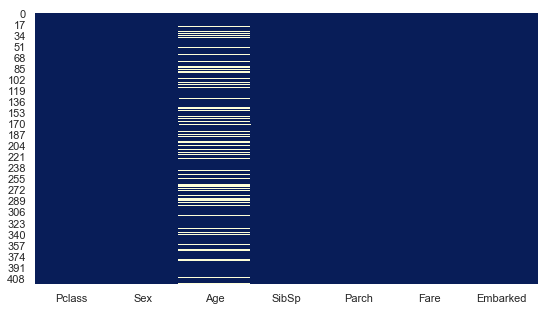

In [51]:
#Check for the missing values in the columns 
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(test.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [52]:
#filling Non valid values with mean for age, 
test['Age'].fillna((test['Age'].mean()), inplace=True)
test['Fare'].fillna((test['Fare'].mean()), inplace=True)

In [53]:
test.loc[ test['Fare'] <= 7.22, 'Fare'] = 0
test.loc[(test['Fare'] > 7.22) & (test['Fare'] <= 21.96), 'Fare'] = 1
test.loc[(test['Fare'] > 21.96) & (test['Fare'] <= 40.82), 'Fare'] = 2
test.loc[ test['Fare'] > 40.82, 'Fare'] = 3

In [54]:
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

In [55]:
test.loc[ test['Age'] <= 16, 'Age'] = 1
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), 'Age'] = 2
test.loc[(test['Age'] > 32) & (test['Age'] <= 64), 'Age'] = 3
test.loc[ test['Age'] > 64, 'Age'] = 4

In [56]:
test['Age*Class'] = test.Age * test.Pclass

In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass        418 non-null int64
Sex           418 non-null object
Age           418 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
Embarked      418 non-null object
FamilySize    418 non-null int64
IsAlone       418 non-null int64
Age*Class     418 non-null float64
dtypes: float64(3), int64(5), object(2)
memory usage: 32.7+ KB


In [58]:
#as in the train dataset, build dummis in the sex and embarked columns
test_dummies_Sex = pd.get_dummies(test.Sex)
test_dummies_Embarked = pd.get_dummies(test.Embarked)
test_ready = pd.concat([test, test_dummies_Sex,test_dummies_Embarked], axis=1)
test_ready.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Age*Class,female,male,C,Q,S
0,3,male,3.0,0,0,1.0,Q,1,1,9.0,0,1,0,1,0
1,3,female,3.0,1,0,0.0,S,2,0,9.0,1,0,0,0,1
2,2,male,3.0,0,0,1.0,Q,1,1,6.0,0,1,0,1,0
3,3,male,2.0,0,0,1.0,S,1,1,6.0,0,1,0,0,1
4,3,female,2.0,1,1,1.0,S,3,0,6.0,1,0,0,0,1


In [59]:
#drop these columns, we keep only numerical values
#train_ready = train_ready.drop(columns = ['Sex','Embarked','Survived','SibSp','Parch'])
test_ready = test_ready.drop(columns = ['Sex','Embarked'])

When dropping the colmuns in the train dataset it would be neccesary to do the same in the test dataset:

In [60]:
#test_ready = test_ready.drop(columns = ['Age*Class'])

In [61]:
#test_ready = test_ready.drop(columns = ['FamilySize'])

In [62]:
#check all is ok 
test_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
Pclass        418 non-null int64
Age           418 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
FamilySize    418 non-null int64
IsAlone       418 non-null int64
Age*Class     418 non-null float64
female        418 non-null uint8
male          418 non-null uint8
C             418 non-null uint8
Q             418 non-null uint8
S             418 non-null uint8
dtypes: float64(3), int64(5), uint8(5)
memory usage: 28.2 KB


In [63]:
test_ready.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Age*Class,female,male,C,Q,S
0,3,3.0,0,0,1.0,1,1,9.0,0,1,0,1,0
1,3,3.0,1,0,0.0,2,0,9.0,1,0,0,0,1
2,2,3.0,0,0,1.0,1,1,6.0,0,1,0,1,0
3,3,2.0,0,0,1.0,1,1,6.0,0,1,0,0,1
4,3,2.0,1,1,1.0,3,0,6.0,1,0,0,0,1


I explore the entropy to check wheter the values can give a good learning to the algoritmh

In [64]:
from scipy import stats
for name in test_ready:
    print(name, "column entropy :",round(stats.entropy(test_ready[name].value_counts(normalize=True), base=2),2))

Pclass column entropy : 1.48
Age column entropy : 1.27
SibSp column entropy : 1.24
Parch column entropy : 1.11
Fare column entropy : 1.52
FamilySize column entropy : 1.75
IsAlone column entropy : 0.97
Age*Class column entropy : 2.05
female column entropy : 0.95
male column entropy : 0.95
C column entropy : 0.8
Q column entropy : 0.5
S column entropy : 0.94


<a id="ML"></a> <br> 
**5. Testing several Supervise learning models** 


First, I would use a train/test division on the test csv, and I would check the performance of several algorithms:

In [65]:
## import ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [66]:
# Create arrays for the features and the response variable
y = train_ready['Survived'].values
X = train_ready.drop('Survived',axis=1).values

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=21, stratify=y)

In [68]:
#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

#Models
import warnings
warnings.filterwarnings("ignore")


from eli5.sklearn import PermutationImportance

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

LogReg: 0.794393 (+/- 0.040294)
KNN: 0.820124 (+/- 0.026385)
DecisionTreeClassifier: 0.788072 (+/- 0.023412)
RandomForestClassifier: 0.792820 (+/- 0.040962)
GradientBoostingClassifier: 0.810550 (+/- 0.036568)
RidgeClassifier: 0.792793 (+/- 0.040516)
BaggingRidgeClassifier: 0.789646 (+/- 0.030697)
ExtraTreesClassifier: 0.788098 (+/- 0.022594)


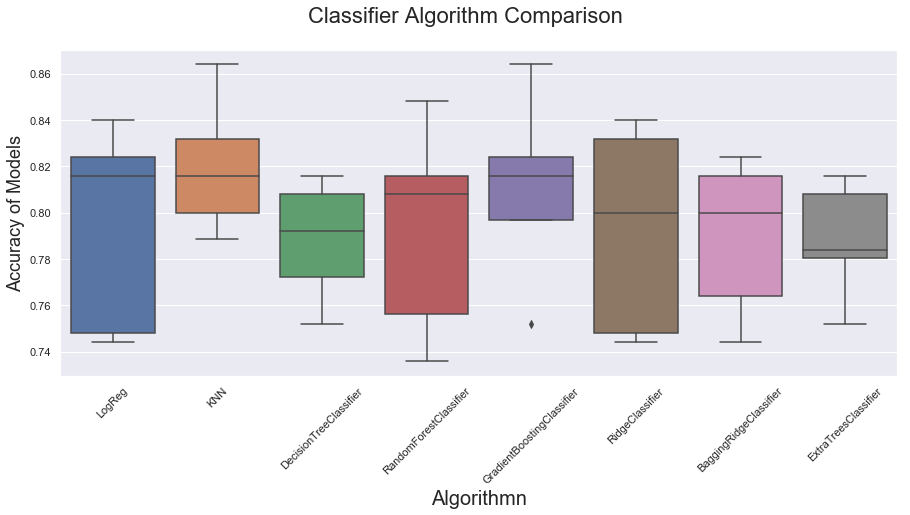

In [69]:
clfs = []
seed = 3

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

#clfs.append(("XGBClassifier",
 #            Pipeline([("Scaler", StandardScaler()),
  #                     ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier(n_neighbors=8))]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=100))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'accuracy'
n_folds = 7

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv= 5, scoring=scoring,
                                 n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [ ]:
#perm_xgb = PermutationImportance(XGBClassifier().fit(X_train, y_train), random_state=1).fit(X_test,y_test)
#eli5.show_weights(perm_xgb, feature_names = train_ready.drop('Survived',axis=1).columns.tolist())

In [70]:
perm_knn = PermutationImportance(KNeighborsClassifier(n_neighbors=8).fit(X_train, y_train), random_state=1).fit(X_test,y_test)
eli5.show_weights(perm_knn, feature_names = train_ready.drop('Survived',axis=1).columns.tolist())

NameError: name 'eli5' is not defined

In [71]:
perm_gbc = PermutationImportance(GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train), random_state=1).fit(X_test,y_test)
eli5.show_weights(perm_gbc, feature_names = train_ready.drop('Survived',axis=1).columns.tolist())

NameError: name 'eli5' is not defined

In [72]:
perm_gbc = PermutationImportance(RidgeClassifier().fit(X_train, y_train), random_state=1).fit(X_test,y_test)
eli5.show_weights(perm_gbc, feature_names = train_ready.drop('Survived',axis=1).columns.tolist())

NameError: name 'eli5' is not defined

In [73]:
#train_ready.drop('Survived',axis=1).columns

In [74]:
train_ready.drop('Survived',axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Pclass        891 non-null int64
Age           891 non-null int32
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null int32
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Age*Class     891 non-null int64
female        891 non-null uint8
male          891 non-null uint8
C             891 non-null uint8
Q             891 non-null uint8
S             891 non-null uint8
dtypes: int32(2), int64(6), uint8(5)
memory usage: 53.2 KB


In [75]:
train_ready.shape

(891, 14)

***Here I can drop the columns as AgexClass and IsAlone to check wheter the algorithms produce better performance ***

**Bulding the model for the test set **

In [76]:
#apply Scla to train in order to standardize data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X)
scaled_features = scaler.transform(X)
train_sc = pd.DataFrame(scaled_features) # columns=df_train_ml.columns[1::])

#apply Scla to test csv (new file)  in order to standardize data 

X_csv_test = test_ready.values  #X_csv_test the new data that is going to be test 
scaler.fit(X_csv_test)
scaled_features_test = scaler.transform(X_csv_test)
test_sc = pd.DataFrame(scaled_features_test) # , columns=df_test_ml.columns)

In [77]:
scaled_features_test.shape

(418, 13)

In [78]:
scaled_features.shape

(891, 13)

<a id="train"></a> <br> 
**6. Trainning all data on several Classifier**

**First Model: KNN**

First we run this loop to detect the correct number of Nieghbors in KNN

Text(0, 0.5, 'Accuracy')

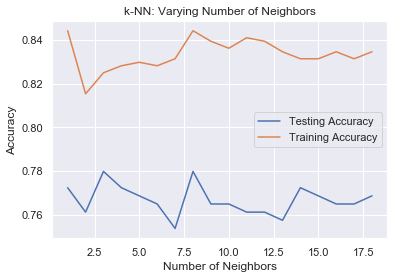

In [79]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier 

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 19)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

**This plot vary depending the features in the train dataframe **

I will keep two of these models, with 6 neighbors and with 10 neighbors

In [80]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier 

# Create a k-NN classifier with 6 neighbors: knn
knn_6 = KNeighborsClassifier(n_neighbors = 6)

# Fit the classifier to the data
knn_6.fit(scaled_features,y)

# Predict the labels for the training data X
y_pred_knn_6 = knn_6.predict(scaled_features_test)

In [81]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier 

# Create a k-NN classifier with 6 neighbors: knn
knn_10 = KNeighborsClassifier(n_neighbors = 10)

# Fit the classifier to the data
knn_10.fit(scaled_features,y)

# Predict the labels for the training data X
y_pred_knn_10 = knn_10.predict(scaled_features_test)

In [82]:
#Upload the test file for KNN (scaled)
#result_knn_6 = pd.read_csv("../input/gender_submission.csv")
#result_knn_6['Survived'] = y_pred_knn_6
#result_knn_6.to_csv('Titanic_knn_5.csv', index=False)

FileNotFoundError: [Errno 2] File b'../input/gender_submission.csv' does not exist: b'../input/gender_submission.csv'

In [ ]:
#Upload the test file for KNN (scaled)
#result_knn_10 = pd.read_csv("../input/gender_submission.csv")
#result_knn_10['Survived'] = y_pred_knn_10
#result_knn_10.to_csv('Titanic_knn_7.csv', index=False)

**Second model: Logistic Regression**

In [ ]:
logreg = LogisticRegression()
logreg.fit(scaled_features,y)
y_pred_logreg = logreg.predict(scaled_features_test)
y_pred_logreg.shape

In [ ]:
#Upload the test file for Random Forest 
#result_logreg = pd.read_csv("../input/gender_submission.csv")
#result_logreg['Survived'] = y_pred_logreg
#result_logreg.to_csv('Titanic_logreg.csv', index=False)

**Third model : XGB Classifier**

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

clf = xgb.XGBClassifier(n_estimators=250, random_state=4,bagging_fraction= 0.791787170136272, colsample_bytree= 0.7150126733821065,feature_fraction= 0.6929758008695552,gamma= 0.6716290491053838,learning_rate= 0.030240003246947006,max_depth= 2,min_child_samples= 5,num_leaves= 15,reg_alpha= 0.05822089056228967,reg_lambda= 0.14016232510869098,subsample= 0.9)

clf.fit(scaled_features, y)

y_pred_xgb= clf.predict(scaled_features_test)

In [ ]:
#Upload the test file for Random Forest 
result_xgb = pd.read_csv("../input/gender_submission.csv")
result_xgb['Survived'] = y_pred_xgb
result_xgb.to_csv('Titanic_xgb.csv', index=False)

**4th Model RidgeClassifier**

In [ ]:
rcf= RidgeClassifier()
rcf.fit(scaled_features, y)

y_pred_rcf= rcf.predict(scaled_features_test)

In [ ]:
#Upload the test file for  Ridge Classifier
#result_rcf = pd.read_csv("../input/gender_submission.csv")
#result_rcf['Survived'] = y_pred_rcf
#result_rcf.to_csv('Titanic_rcf.csv', index=False)

**5th model: Gradient Boosting Classifier**

In [ ]:
gbc= GradientBoostingClassifier(n_estimators=100)
gbc.fit(scaled_features, y)
y_pred_gbc= gbc.predict(scaled_features_test)

In [ ]:
#Upload the test file for Bagging Ridge Classifie
#result_gbc = pd.read_csv("../input/gender_submission.csv")
#result_gbc['Survived'] = y_pred_gbc
#result_gbc.to_csv('Titanic_gbc.csv', index=False)

<a id="results"></a> <br> 
**7. Results** 


We tested 4 options, first one training without any change in the features

![](https://cdn-images-1.medium.com/max/1000/1*kZ9X3rMW9-Ohxd2UKx-y1w.png)

the next try included all the features created in the first section:

![](https://cdn-images-1.medium.com/max/1000/1*XbtLALV28nrdzBSG5IHm4g.png)

Next, we include only with those features with entropy < 2, that is droping those columns that maybe add more noise than value

![](https://cdn-images-1.medium.com/max/1000/1*Rn1oQJHrDRcDs3_oM6ZxbA.png)

it seems that the global accuracy of all the models is increasing
Next, we select only those features with entropy < 1,5 :

![](https://cdn-images-1.medium.com/max/1000/1*ofXtRDzL5PtXvhIT0Qdk1A.png)

It seems this feature combination give the better accuracy for all the algorithms

Another point, for example, when trainning a KNN with several neighbords, the result depend on the features defined.
We plot the accuracy of KNN for several neighbors:

![](https://cdn-images-1.medium.com/max/1000/1*xZwK315Z-wxV5EmqGI9y9Q.png)


After submitting the diferent CSV I have obatined this results:
- Using Random Forest: 0.73684
- Using KNN with 6 neighboors:  **0.77990**
- Using KNN with 10 neighboors: 0.77033
- Using KGBClassifier:** 0.77990**
- Using Ridge Classifier: 0.77511

 <font color="red">If this kernel were useful for you, please <b>UPVOTE</b> the kernel ;)</font>